# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import optimizers
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv1D, MaxPooling1D

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

# Load data

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

In [4]:
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
print('Train set overview:')
display(train.head())

Train set shape: (262144, 258)
Test set shape: (131073, 257)
Train set overview:


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

## Preprocess

In [5]:
train['set'] = 0
test['set'] = 1
data = pd.concat([train, test])

# data['count_magic'] = data.groupby(['wheezy-copper-turtle-magic'])['id'].transform('count')
data = pd.concat([data, pd.get_dummies(data['wheezy-copper-turtle-magic'], prefix='magic', drop_first=True)], axis=1).drop(['wheezy-copper-turtle-magic'], axis=1)

In [6]:
data.drop('id', axis=1, inplace=True)
train = data[data['set'] == 0]
test = data[data['set'] == 1]
labels = train['target']
train.drop(['target', 'set'], axis=1, inplace=True)
test.drop(['target', 'set'], axis=1, inplace=True)

### Normalize data using MinMaxScaler

In [7]:
non_cat_features = list(train.filter(regex='^(?!magic_)'))
scaler = MinMaxScaler()
train[non_cat_features] = scaler.fit_transform(train[non_cat_features])
test[non_cat_features] = scaler.transform(test[non_cat_features])

# Model

## Model parameters

In [8]:
N_FOLDS = 5
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
ES_PATIENCE = 5
RLROP_PATIENCE = 3
RLROP_FACTOR = 0.5

es = EarlyStopping(monitor='val_auc', mode='max', patience=ES_PATIENCE, restore_best_weights=True, min_delta=0.005, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=RLROP_PATIENCE, factor=RLROP_FACTOR, min_lr=1e-6, verbose=1)
callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def model_fn():
    model = Sequential()
    model.add(Dense(1024, input_dim=X_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['binary_accuracy', auc])
    
    return model

In [10]:
X = train.values
submission['target'] = 0
train['preds'] = 0

skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
counter = 0

for train_index, val_index in skf.split(X, labels):
    counter += 1
    print('Fold {}\n'.format(counter))
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = labels[train_index], labels[val_index]
    
    model = model_fn()
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                        callbacks=callback_list, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        verbose=0)
    
    train_predictions = model.predict_classes(X_train)
    val_predictions = model.predict_classes(X_val)
    
    train_auc = roc_auc_score(Y_train, train_predictions) * 100
    val_auc = roc_auc_score(Y_val, val_predictions) * 100
    train_precision = precision_score(Y_train, train_predictions) * 100
    val_precision = precision_score(Y_val, val_predictions) * 100
    train_recall = recall_score(Y_train, train_predictions) * 100
    val_recall = recall_score(Y_val, val_predictions) * 100
    print('-----Train----------')
    print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
    print('-----Validation-----')
    print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))
    
    # Make predictions
    predictions = model.predict(test)
    submission['target'] += [x[0] for x in predictions]
    train['preds'] += [x[0] for x in model.predict_classes(X)]
    
submission['target'] /= N_FOLDS
train['preds'] /= N_FOLDS

Fold 1

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch
Epoch 00024: early stopping
-----Train----------
AUC: 92.96 Precision: 98.59 Recall: 87.16 

-----Validation-----
AUC: 72.17 Precision: 78.98 Recall: 60.44 

Fold 2

Restoring model weights from the end of the best epoch
Epoch 00021: early stopping
-----Train----------
AUC: 92.74 Precision: 89.79 Recall: 96.46 

-----Validation-----
AUC: 72.85 Precision: 70.16 Recall: 79.57 

Fold 3

Restoring model weights from the end of the best epoch
Epoch 00016: early stopping
-----Train----------
AUC: 88.48 Precision: 93.41 Recall: 82.81 

-----Validation-----
AUC: 72.11 Precision: 76.50 Recall: 63.87 

Fold 4

Restoring model weights from the end of the best epoch
Epoch 00019: early stopping
-----Train----------
AUC: 91.52 Precision: 88.91 Recall: 94.89 

-----Validation---

### Model graph loss

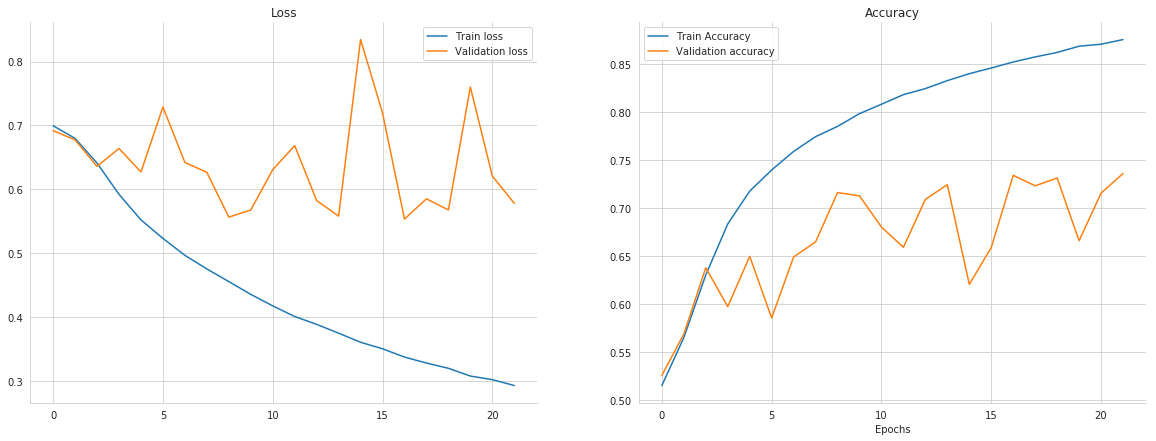

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20, 7))

ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['binary_accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_binary_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model evaluation
## Confusion matrix

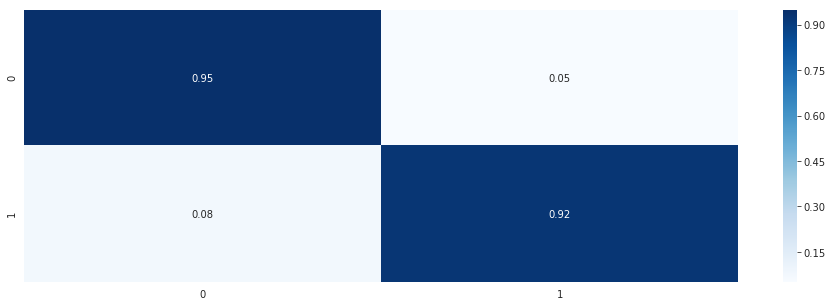

In [12]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(labels, [np.round(x) for x in train['preds']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Metrics ROC AUC

In [13]:
print('AUC %.2f' % roc_auc_score(labels, train['preds']))

AUC 0.98


# Test predictions

In [14]:
submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.556196
1,ba88c155ba898fc8b5099893036ef205,0.720405
2,7cbab5cea99169139e7e6d8ff74ebb77,0.697118
3,ca820ad57809f62eb7b4d13f5d4371a0,0.336065
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.070794
5,8b3116e5e3e92e971dac305d1a093bf6,0.545881
6,35cfd7cab9bfa29bc963d1b8c94dd280,0.024382
7,83cf532df8ff4642a3e33a70fffdac37,0.670023
8,2e1350fe94ec9f2220bec5245e5e9265,0.449527
9,e62020afa72eb54a15725473e3a8475b,0.352753
